In [1]:
import os
import json
import csv
import re
import emoji
import html
import os
import random
from unsloth import FastLanguageModel  # Tool for loading the model
from datasets import Dataset
from trl import SFTTrainer  # For supervised fine-tuning
from transformers import TrainingArguments  # For configuring training parameters
from unsloth import is_bfloat16_supported  # Check if bfloat16 is supported
import math
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # Evaluation metrics
import matplotlib.pyplot as plt

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 05-29 15:16:51 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 05-29 15:16:51 [__init__.py:239] Automatically detected platform cuda.


# 1. Data Preprocessing

In [2]:
def process_tweets(csv_file, label):
    tweets_with_labels = []
    # Regular expressions for removing URLs and line breaks
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    newline_pattern = re.compile(r'\n')
    
    # Check if file exists
    if not os.path.exists(csv_file):
        print(f"File not found: {csv_file}")
        return tweets_with_labels  # Return empty list or handle error

    try:
        with open(csv_file, mode='r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            for row in reader:
                tweet_text = row.get('Tweet')
                if tweet_text:
                    # Decode HTML entities, e.g., &amp; → &
                    cleaned_text = html.unescape(tweet_text)

                    # Remove mentions (@user)
                    cleaned_text = re.sub(r'@\w+', '', cleaned_text)
                    
                    # Remove leading hashtags
                    cleaned_text = re.sub(r'^(#\w+\s*)+', '', cleaned_text)

                    # Remove URLs and line breaks
                    cleaned_text = url_pattern.sub(r'', cleaned_text)
                    cleaned_text = newline_pattern.sub(r' ', cleaned_text)  # Replace newlines with space
                    
                    # Remove emojis using emoji library
                    cleaned_text = emoji.replace_emoji(cleaned_text, '')
                    
                    # Remove remaining non-ASCII characters
                    cleaned_text = re.sub(r'[^\x00-\x7F]+', '', cleaned_text)

                    cleaned_text = cleaned_text.strip()  # Remove leading/trailing spaces
                    
                    # Add to list if not empty
                    if cleaned_text:
                         tweets_with_labels.append({"text": cleaned_text, "label": label})
    except Exception as e:
        print(f"Error processing file {csv_file}: {e}")
        
    return tweets_with_labels

In [3]:
# Process all CSV files in a given directory
def process_directory_tweets(directory_path, label):
    processed_data = []
    print(f"Processing directory: {directory_path}")
    if not os.path.isdir(directory_path):
        print(f"Directory not found: {directory_path}")
        return processed_data

    try:
        csv_files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
        for file_name in csv_files:
            file_path = os.path.join(directory_path, file_name)
            print(f"Processing file: {file_path}")
            processed_data_single_file = process_tweets(file_path, label)
            processed_data.extend(processed_data_single_file)
    except Exception as e:
        print(f"Error processing directory {directory_path}: {e}")
        
    return processed_data

In [4]:
# Paths to folders containing CSV files
negative_data_directory = 'Datasets/Negative CSV'
positive_data_directory = 'Datasets/Positive CSV'

all_processed_data = []

# Process negative samples
all_processed_data.extend(process_directory_tweets(negative_data_directory, 1))

# Process positive samples
all_processed_data.extend(process_directory_tweets(positive_data_directory, 0))

# Shuffle all processed data
random.shuffle(all_processed_data)

# Save cleaned data to JSON file
output_json_file = 'cleaned_trained_data.json'
with open(output_json_file, 'w', encoding='utf-8') as f:
    json.dump(all_processed_data, f, ensure_ascii=False, indent=4)

print(f"Cleaned data saved to {output_json_file}")

# Print total number of processed tweets
print(f"Total processed tweets: {len(all_processed_data)}")

Processing directory: Datasets/Negative CSV
Processing file: Datasets/Negative CSV/hatewomen.csv
Processing file: Datasets/Negative CSV/hatemen.csv
Processing file: Datasets/Negative CSV/menaretrash.csv
Processing file: Datasets/Negative CSV/Misandry.csv
Processing file: Datasets/Negative CSV/womenarebaddrivers.csv
Processing file: Datasets/Negative CSV/womenarestupid.csv
Processing directory: Datasets/Positive CSV
Processing file: Datasets/Positive CSV/equalityofsexes.csv
Processing file: Datasets/Positive CSV/breastfeeding.csv
Processing file: Datasets/Positive CSV/genderpaygap.csv
Processing file: Datasets/Positive CSV/lgbtq.csv
Cleaned data saved to cleaned_trained_data.json
Total processed tweets: 1885


# 2.Train the model

## 2.1 Evaluate function

In [5]:
# Model evaluation function
def evaluate_model(model, tokenizer, evaluation_data, instruction):
    """Evaluate model performance using accuracy, precision, recall, and F1 score (binary labels)"""
    model.eval()
    true_labels_list = []
    pred_labels_list = []
    
    print("\nEvaluating model...")
    with torch.no_grad():
        for item in tqdm(evaluation_data, desc="Evaluating"):
            tweet_text = item.get("text")
            true_label_numeric = item.get("label")
            
            if tweet_text is None or true_label_numeric is None:
                continue
                
            prompt = f"Instruction: {instruction}\nInput: {tweet_text}\nOutput:"
            inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048)
            inputs = {k: v.to(model.device) for k, v in inputs.items()} 
            
            outputs = model.generate(
                **inputs,
                max_new_tokens=10,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id
            )
            
            response = tokenizer.decode(outputs[0], skip_special_tokens=True)
            
            try:
                output_start = response.rindex("Output:")
                output_text = response[output_start + 7:].strip()
                pred_label = output_text.split()[0].strip()
                if pred_label not in ['1', '0']:
                     pred_label = ''

            except (ValueError, IndexError):
                pred_label = ""
            
            true_labels_list.append(str(true_label_numeric))
            if pred_label == '1':
                 pred_label_for_list = '1'
            elif pred_label == '0':
                 pred_label_for_list = '0'
            else:
                 if true_label_numeric == 1:
                      pred_label_for_list = '0'
                 else:
                      pred_label_for_list = '1'

            pred_labels_list.append(pred_label_for_list)
    
    # Calculate evaluation metrics
    if len(true_labels_list) > 0:
        true_labels_list = [str(label) for label in true_labels_list]
        pred_labels_list = [str(label) for label in pred_labels_list]

        accuracy = accuracy_score(true_labels_list, pred_labels_list)
        try:
            precision = precision_score(true_labels_list, pred_labels_list, pos_label='1', zero_division=0)
        except ValueError:
            precision = 0.0
        try:
            recall = recall_score(true_labels_list, pred_labels_list, pos_label='1', zero_division=0)
        except ValueError:
             recall = 0.0
        try:
            f1 = f1_score(true_labels_list, pred_labels_list, pos_label='1', zero_division=0)
        except ValueError:
            f1 = 0.0

        print(f"Total samples: {len(true_labels_list)}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
    else:
        accuracy = 0.0
        print("\nNo valid evaluation data found.")
        
    return accuracy

## 2.2 Prepare Train Data

In [6]:
# Load cleaned JSON data
with open("cleaned_trained_data.json", "r", encoding='utf-8') as f:
    all_data = json.load(f)

# Split into training and test set (90% training, 10% test)
train_size = int(len(all_data) * 0.9)
train_data = all_data[:train_size]
test_data = all_data[train_size:]

# Load pretrained model and tokenizer
max_seq_length = 2048
dtype = None
load_in_4bit = True 

model, tokenizer= FastLanguageModel.from_pretrained(
    model_name = "Qwen2.5-0.5B-Instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit
)
EOS_TOKEN = tokenizer.eos_token
# Instruction: output 1 or 0
instruction = "Determine whether the following sentence contains gender discrimination. Reply with \"1\" for yes and \"0\" for no. Only reply 1 or 0."

==((====))==  Unsloth 2025.3.19: Fast Qwen2 patching. Transformers: 4.51.3. vLLM: 0.8.5.post1.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.65 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Sliding Window Attention is enabled but not implemented for `eager`; unexpected results may be encountered.


In [7]:
# Prepare training data
instruction_texts = []    
for item in train_data:
    tweet_text = item.get("text")
    label_numeric = item.get("label")
    
    if tweet_text is not None and label_numeric is not None:
        formatted_text = f"Instruction: {instruction}\nInput: {tweet_text}\nOutput: {label_numeric}" + EOS_TOKEN
        instruction_texts.append(formatted_text)

dataset = {"text": instruction_texts}
dataset_length = len(instruction_texts)
dataset = Dataset.from_dict(dataset)

## 2.3 Evaluate the original model

In [8]:
# Evaluate model before fine-tuning
print("Evaluating model before fine-tuning...")
evaluate_model(model, tokenizer, test_data, instruction)

Evaluating model before fine-tuning...

Evaluating model...


Evaluating: 100%|██████████| 189/189 [01:05<00:00,  2.91it/s]

Total samples: 189
Accuracy: 0.3598
Precision: 0.3820
Recall: 0.3400
F1 Score: 0.3598


0.35978835978835977

## 2.4 Set training parameters and start training

In [9]:
# Set the model to training mode and enable gradient computation (usually activates dropout and other training-related mechanisms)
FastLanguageModel.for_training(model)

# Apply LoRA (Low-Rank Adaptation) for parameter-efficient fine-tuning
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,  # Rank of LoRA; higher values give more expressive power but require more trainable parameters
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],  # Names of modules where LoRA layers will be inserted
    lora_alpha = 64,  # Scaling factor for adjusting the output of LoRA layers
    lora_dropout = 0,  # Dropout probability for LoRA layers; 0 means no dropout
    bias = "none",  # Whether to train bias terms; "none" means do not train them
    use_gradient_checkpointing = "unsloth",  # Enable gradient checkpointing to save memory, using unsloth implementation
    random_state = 3407,  # Random seed for reproducibility
    use_rslora = False,  # Whether to use reparameterized structured LoRA (disabled here)
    loftq_config = None,  # Configuration for quantization; LoftQ is not used here
)

# Calculate steps per epoch (dataset length divided by effective batch size per step)
steps_per_epoch = math.ceil(dataset_length / (32 * 2))  # batch_size=32, gradient_accumulation=2 → effective batch=64
max_steps = steps_per_epoch * 3  # Set total training steps to cover 3 epochs

# Create a supervised fine-tuning trainer (SFTTrainer)
trainer = SFTTrainer(
    model=model,  # The model to be trained
    tokenizer=tokenizer,  # The tokenizer
    train_dataset=dataset,  # Training dataset
    dataset_text_field="text",  # Field in the dataset used for training
    max_seq_length=max_seq_length,  # Maximum input sequence length
    dataset_num_proc=8,  # Number of processes for preprocessing
    packing=False,  # Whether to pack multiple samples together; False means each sample is processed separately
    args=TrainingArguments(  # Training hyperparameter configuration
        per_device_train_batch_size=32,  # Batch size per device
        gradient_accumulation_steps=2,  # Accumulate gradients every 2 batches (simulate larger batch size)
        warmup_steps=5,  # Number of warmup steps for learning rate
        max_steps=max_steps,  # Total number of training steps
        learning_rate=2e-4,  # Initial learning rate
        fp16=not is_bfloat16_supported(),  # Use fp16 if bfloat16 is not supported (to save memory)
        bf16=is_bfloat16_supported(),  # Use bfloat16 if supported (more stable)
        logging_steps=1,  # Log every training step
        optim="adamw_torch",  # Use AdamW optimizer (PyTorch implementation)
        weight_decay=0.01,  # Weight decay factor to prevent overfitting
        lr_scheduler_type="linear",  # Linear learning rate scheduler
        seed=3407,  # Random seed
        output_dir="outputs",  # Output directory for models and logs
        report_to="none",  # Do not use external logging tools like wandb
    ),
)

# Start training
trainer_stats = trainer.train()  # Begin training

Unsloth 2025.3.19 patched 24 layers with 24 QKV layers, 24 O layers and 24 MLP layers.


Unsloth: Tokenizing ["text"] (num_proc=8):   0%|          | 0/1696 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,696 | Num Epochs = 4 | Total steps = 81
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 2 x 1) = 64
 "-____-"     Trainable parameters = 8,798,208/5,000,000,000 (0.18% trained)


Unsloth: Will smartly offload gradients to save VRAM!



Plotting training loss curve...


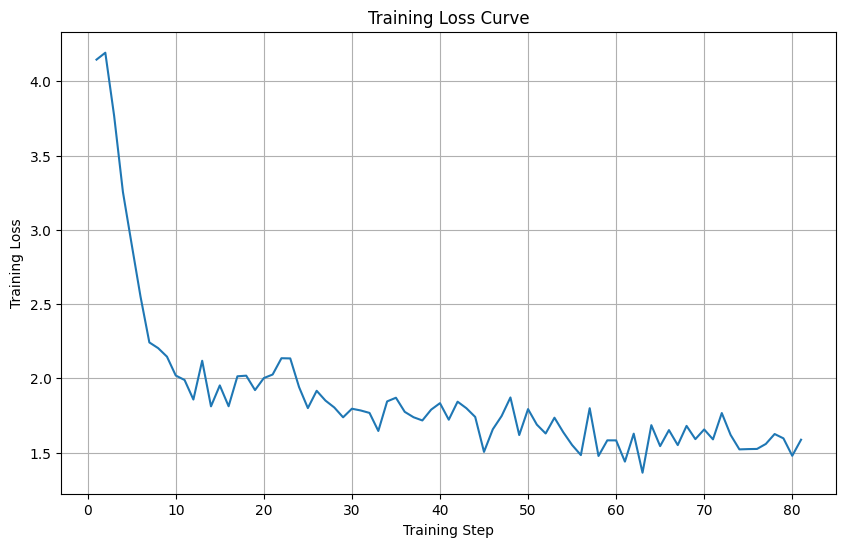

In [12]:
# Extract and plot the loss curve
print("\nPlotting training loss curve...")
logging_history = trainer.state.log_history
steps = []
losses = []
for entry in logging_history:
    if 'loss' in entry:
        steps.append(entry['step'])
        losses.append(entry['loss'])

if steps and losses:
    plt.figure(figsize=(10, 6))
    plt.plot(steps, losses)
    plt.xlabel("Training Step")
    plt.ylabel("Training Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.show()
else:
    print("Not enough loss data to plot the curve.")

## 2.5 Evaluate the fine-tuned model

In [13]:
# Evaluate the fine-tuned model (directly using the pre-split test set)
print("\nEvaluating the fine-tuned model...")
evaluate_model(model, tokenizer, test_data, instruction)


Evaluating the fine-tuned model...

Evaluating model...


Evaluating: 100%|██████████| 189/189 [00:33<00:00,  5.58it/s]

Total samples: 189
Accuracy: 0.9524
Precision: 0.9505
Recall: 0.9600
F1 Score: 0.9552


0.9523809523809523

# 3. Save the fine-tuned model

In [14]:
# Save the fine-tuned model
output_dir = "finetuned_model"
os.makedirs(output_dir, exist_ok=True)
print(f"\nSaving the fine-tuned model locally to: {output_dir}")
model.save_pretrained_merged(output_dir, tokenizer, save_method = "merged_16bit")
print("Model saved successfully.")

print("Model training and evaluation completed!")


Saving the fine-tuned model locally to: finetuned_model
Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 643.81 out of 1007.51 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 24/24 [00:00<00:00, 122.66it/s]


Unsloth: Saving tokenizer... Done.
Done.
Model saved successfully.
Model training and evaluation completed!
